# Outlier Detection

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from scipy.spatial.distance import euclidean

from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN 
from sklearn.ensemble import IsolationForest

## Dataset

In [2]:
# Artificial Dataset
X, y = make_moons(n_samples=1000, noise=0.1, random_state=666)
df = pd.DataFrame(data = X, columns=["feature_1", "feature_2"])
df["target"] = y

In [3]:
# Add Outliers 
np.random.seed(666)
index_sample = np.random.randint(0, len(df), 10)
df.loc[index_sample, "feature_1"] = df.loc[index_sample, "feature_1"] + np.random.normal(0, 0.5)
np.random.seed(665)
df.loc[index_sample, "feature_2"] = df.loc[index_sample, "feature_2"] + np.random.normal(0, 0.5)
df.loc[index_sample, "target"] = -1 

# Normalize
df["feature_1"] = (df["feature_1"] - df["feature_1"].min()) / (df["feature_1"].max() - df["feature_1"].min())
df["feature_2"] = (df["feature_2"] - df["feature_2"].min()) / (df["feature_2"].max() - df["feature_2"].min())

df

,feature_1,feature_2,target
0,0.366586,0.593236,1
1,0.094681,0.739544,0
2,0.577789,0.809714,0
3,0.375748,0.598722,1
4,0.921173,0.621515,1
...,...,...,...
995,0.825842,0.363310,1
996,0.914147,0.509484,1
997,0.102161,0.613653,0
998,0.825430,0.478923,1


Text(0.5, 1.0, 'Moons with Outliers')

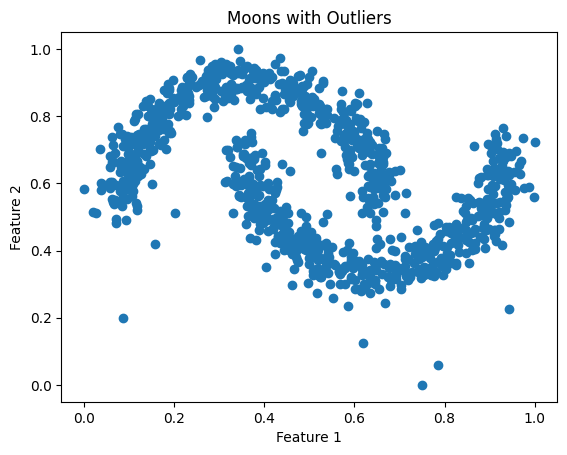

In [4]:
# Plot
plt.scatter(df["feature_1"], df["feature_2"])
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Moons with Outliers")

## Interquantile Range

In [5]:
q1_feature_1 = df["feature_1"].quantile(q = 0.25)
q3_feature_1 = df["feature_1"].quantile(q = 0.75)

interquantile_range_feature_1 = q3_feature_1 - q1_feature_1

q1_feature_2 = df["feature_2"].quantile(q = 0.25)
q3_feature_2 = df["feature_2"].quantile(q = 0.75)

interquantile_range_feature_2 = q3_feature_2 - q1_feature_2

print(f'{interquantile_range_feature_1 = }')
print(f'{interquantile_range_feature_2 = }')

interquantile_range_feature_1 = 0.32794909769659336
interquantile_range_feature_2 = 0.33108794993215246


In [6]:
def interquantile_outliers(df):

    df_copy = df.copy()

    df_copy["interquantile_outliers"] = 0 
    i_score = 0.8

    outlier_feature_1 = (df_copy["feature_1"] >= q3_feature_1 + i_score*interquantile_range_feature_1) | (df_copy["feature_1"] <= q1_feature_1 - i_score*interquantile_range_feature_1)
    outlier_feature_2 = (df_copy["feature_2"] >= q3_feature_2 + i_score*interquantile_range_feature_2) | (df_copy["feature_2"] <= q1_feature_2 - i_score*interquantile_range_feature_2)

    df_copy.loc[outlier_feature_1 | outlier_feature_2, "interquantile_outliers"] = -1 

    return df_copy 

df = interquantile_outliers(df)
df

,feature_1,feature_2,target,interquantile_outliers
0,0.366586,0.593236,1,0
1,0.094681,0.739544,0,0
2,0.577789,0.809714,0,0
3,0.375748,0.598722,1,0
4,0.921173,0.621515,1,0
...,...,...,...,...
995,0.825842,0.363310,1,0
996,0.914147,0.509484,1,0
997,0.102161,0.613653,0,0
998,0.825430,0.478923,1,0


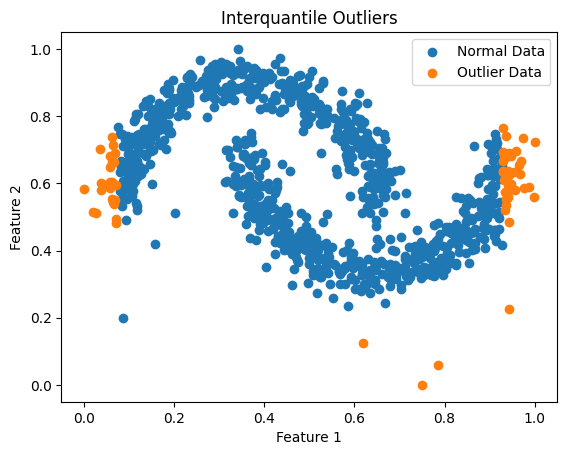

In [7]:
for c in df["interquantile_outliers"].unique():
        df_loc = df.loc[df["interquantile_outliers"] == c].copy()
        if c == -1: 
            plt.scatter(df_loc.feature_1, df_loc.feature_2, label = "Outlier Data")
        else: 
            plt.scatter(df_loc.feature_1, df_loc.feature_2, label = "Normal Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.title("Interquantile Outliers")
plt.show()

## Z - Score

In [8]:
z_score = 1.96 

### 1D Distance

In [9]:
mean_feature_1 = df["feature_1"].mean() 
mean_feature_2 = df["feature_2"].mean()

std_feature_1 = df["feature_1"].std() 
std_feature_2 = df["feature_2"].std()

print(f'{mean_feature_1 = }, {mean_feature_2 = }')
print(f'{std_feature_1 = }, {std_feature_2 = }')

mean_feature_1 = 0.5027079843665391, mean_feature_2 = 0.6173494867572519
std_feature_1 = 0.25068998736694303, std_feature_2 = 0.19281415323932413


In [10]:
def z_score_1d_outliers(df):

    df_copy = df.copy()

    df_copy["z_score_1d_outliers"] = 0 

    outlier_feature_1 = np.abs((df_copy["feature_1"] - mean_feature_1)/std_feature_1) >= z_score 
    outlier_feature_2 = np.abs((df_copy["feature_2"] - mean_feature_2)/std_feature_2) >= z_score 

    df_copy.loc[outlier_feature_1 | outlier_feature_2, "z_score_1d_outliers"] = -1 

    return df_copy

df = z_score_1d_outliers(df)
df

,feature_1,feature_2,target,interquantile_outliers,z_score_1d_outliers
0,0.366586,0.593236,1,0,0
1,0.094681,0.739544,0,0,0
2,0.577789,0.809714,0,0,0
3,0.375748,0.598722,1,0,0
4,0.921173,0.621515,1,0,0
...,...,...,...,...,...
995,0.825842,0.363310,1,0,0
996,0.914147,0.509484,1,0,0
997,0.102161,0.613653,0,0,0
998,0.825430,0.478923,1,0,0


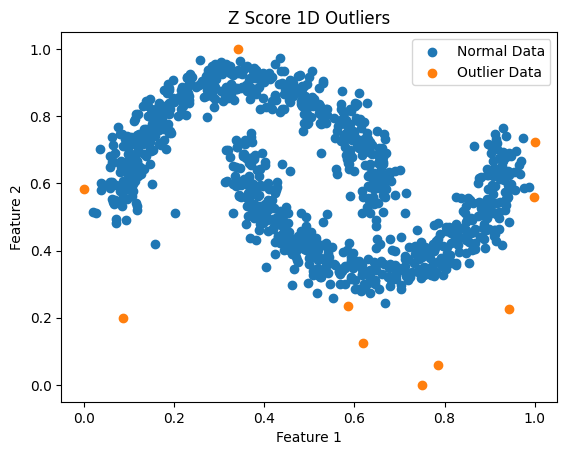

In [12]:
for c in df["z_score_1d_outliers"].unique():
        df_loc = df.loc[df["z_score_1d_outliers"] == c].copy()
        if c == -1: 
            plt.scatter(df_loc.feature_1, df_loc.feature_2, label = "Outlier Data")
        else: 
            plt.scatter(df_loc.feature_1, df_loc.feature_2, label = "Normal Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.title("Z Score 1D Outliers")
plt.show()

### 2D Distance

In [13]:
def mahalanobis_distance(u, u_mean, V):

    diff = u - u_mean 
    mat_mul = diff @ V @ diff.T

    distance = np.sqrt(mat_mul)

    return distance

# Calculate the mean and covariance matrix
X = df[["feature_1", "feature_2"]].to_numpy()

mean = np.mean(X, axis=0)
covariance_matrix = np.cov(X, rowvar=False)
inverse_covariance_matrix = np.linalg.inv(covariance_matrix)

In [14]:
def z_score_2d_outliers(df):

    df_copy = df.copy() 

    df_copy["mahalanobis_distance"] = df_copy[["feature_1", "feature_2"]].apply(lambda row: mahalanobis_distance(row, mean, inverse_covariance_matrix), axis=1)

    outlier_two_features = (df_copy["mahalanobis_distance"] >= z_score)

    df_copy["z_score_2d_outliers"] = 0
    df_copy.loc[outlier_two_features, "z_score_2d_outliers"] = -1 

    return df_copy 

df = z_score_2d_outliers(df)
df

,feature_1,feature_2,target,interquantile_outliers,z_score_1d_outliers,mahalanobis_distance,z_score_2d_outliers
0,0.366586,0.593236,1,0,0,0.672622,0
1,0.094681,0.739544,0,0,0,1.629245,0
2,0.577789,0.809714,0,0,0,1.282928,0
3,0.375748,0.598722,1,0,0,0.614512,0
4,0.921173,0.621515,1,0,0,1.859109,0
...,...,...,...,...,...,...,...
995,0.825842,0.363310,1,0,0,1.541611,0
996,0.914147,0.509484,1,0,0,1.649165,0
997,0.102161,0.613653,0,0,0,1.778775,0
998,0.825430,0.478923,1,0,0,1.300187,0


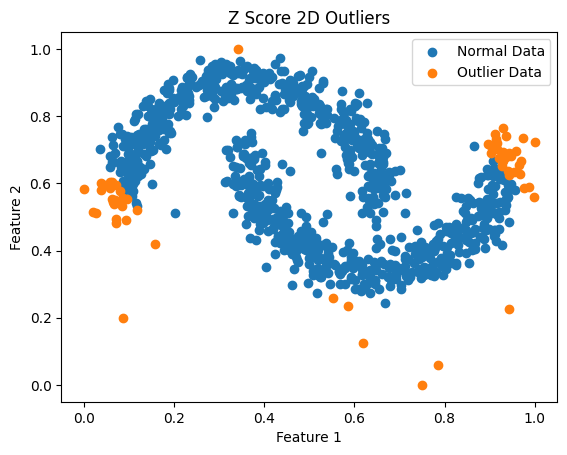

In [15]:
for c in df["z_score_2d_outliers"].unique():
        df_loc = df.loc[df["z_score_2d_outliers"] == c].copy()
        if c == -1: 
            plt.scatter(df_loc.feature_1, df_loc.feature_2, label = "Outlier Data")
        else: 
            plt.scatter(df_loc.feature_1, df_loc.feature_2, label = "Normal Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.title("Z Score 2D Outliers")
plt.show()

## DBSCAN

In [16]:
def dbscan_predict(dbscan_model, X_new, metric=euclidean):
    # Result is noise by default
    y_new = np.ones(shape=len(X_new), dtype=int)*-1 

    # Iterate all input samples for a label
    for j, x_new in enumerate(X_new):
        # Find a core sample closer than EPS
        for i, x_core in enumerate(dbscan_model.components_): 
            if metric(x_new, x_core) < dbscan_model.eps:
                # Assign label of x_core to x_new
                y_new[j] = dbscan_model.labels_[dbscan_model.core_sample_indices_[i]]
                break

    return y_new

In [17]:
clustering = DBSCAN(eps=0.08, min_samples=10).fit(X)

def dbscan_outliers(df, predict = False):

    df_copy = df.copy() 

    if predict:
        df_copy["dbscan_outliers"] = dbscan_predict(clustering, df_copy[["feature_1", "feature_2"]].to_numpy())
    else:
        df_copy["dbscan_outliers"] = clustering.labels_

    return df_copy

df = dbscan_outliers(df, predict=False)
df

,feature_1,feature_2,target,interquantile_outliers,z_score_1d_outliers,mahalanobis_distance,z_score_2d_outliers,dbscan_outliers
0,0.366586,0.593236,1,0,0,0.672622,0,0
1,0.094681,0.739544,0,0,0,1.629245,0,0
2,0.577789,0.809714,0,0,0,1.282928,0,0
3,0.375748,0.598722,1,0,0,0.614512,0,0
4,0.921173,0.621515,1,0,0,1.859109,0,0
...,...,...,...,...,...,...,...,...
995,0.825842,0.363310,1,0,0,1.541611,0,0
996,0.914147,0.509484,1,0,0,1.649165,0,0
997,0.102161,0.613653,0,0,0,1.778775,0,0
998,0.825430,0.478923,1,0,0,1.300187,0,0


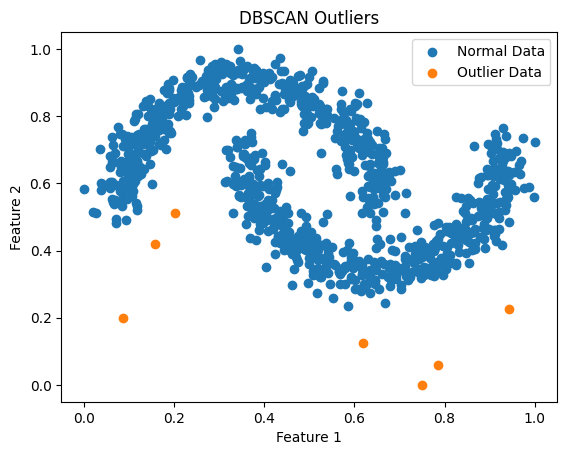

In [18]:
for c in df["dbscan_outliers"].unique():
        df_loc = df.loc[df["dbscan_outliers"] == c].copy()
        if c == -1: 
            plt.scatter(df_loc.feature_1, df_loc.feature_2, label = "Outlier Data")
        else: 
            plt.scatter(df_loc.feature_1, df_loc.feature_2, label = "Normal Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.title("DBSCAN Outliers")
plt.show()

## Isolation Forest

In [19]:
iso_forest = IsolationForest(n_estimators=100, random_state=0, contamination=0.01).fit(X) 

def iso_forest_outliers(df):

    df_copy = df.copy() 

    df_copy["iso_forest_outliers"] = iso_forest.predict(df_copy[["feature_1", "feature_2"]].to_numpy())

    return df_copy

df = iso_forest_outliers(df)
df

,feature_1,feature_2,target,interquantile_outliers,z_score_1d_outliers,mahalanobis_distance,z_score_2d_outliers,dbscan_outliers,iso_forest_outliers
0,0.366586,0.593236,1,0,0,0.672622,0,0,1
1,0.094681,0.739544,0,0,0,1.629245,0,0,1
2,0.577789,0.809714,0,0,0,1.282928,0,0,1
3,0.375748,0.598722,1,0,0,0.614512,0,0,1
4,0.921173,0.621515,1,0,0,1.859109,0,0,1
...,...,...,...,...,...,...,...,...,...
995,0.825842,0.363310,1,0,0,1.541611,0,0,1
996,0.914147,0.509484,1,0,0,1.649165,0,0,1
997,0.102161,0.613653,0,0,0,1.778775,0,0,1
998,0.825430,0.478923,1,0,0,1.300187,0,0,1


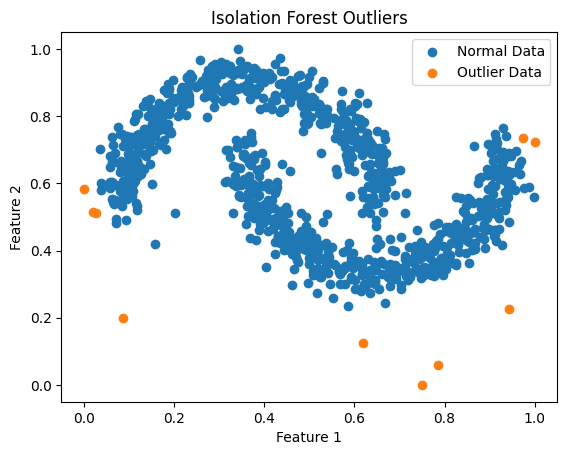

In [20]:
for c in df["iso_forest_outliers"].unique():
        df_loc = df.loc[df["iso_forest_outliers"] == c].copy()
        if c == -1: 
            plt.scatter(df_loc.feature_1, df_loc.feature_2, label = "Outlier Data")
        else: 
            plt.scatter(df_loc.feature_1, df_loc.feature_2, label = "Normal Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.title("Isolation Forest Outliers")
plt.show()

## Contour Plot

In [22]:
# Grid 
X1, X2 = np.meshgrid(np.arange(start = 0, stop = 1.01, step = 0.01), np.arange(start = 0, stop = 1.01, step = 0.01))
grid = np.array([X1.ravel(), X2.ravel()]).T

mapping = pd.DataFrame()
mapping["feature_1"] = grid[: , 0]
mapping["feature_2"] = grid[: , 1]

# Interquantile 
mapping = interquantile_outliers(mapping)
mapping = z_score_2d_outliers(mapping)
mapping = dbscan_outliers(mapping, predict = True)
mapping = iso_forest_outliers(mapping)

mapping

,feature_1,feature_2,interquantile_outliers,mahalanobis_distance,z_score_2d_outliers,dbscan_outliers,iso_forest_outliers
0,0.00,0.0,-1,4.927025,-1,-1,-1
1,0.01,0.0,-1,4.893531,-1,-1,-1
2,0.02,0.0,-1,4.860208,-1,-1,-1
3,0.03,0.0,-1,4.827058,-1,-1,-1
4,0.04,0.0,-1,4.794087,-1,-1,-1
...,...,...,...,...,...,...,...
10196,0.96,1.0,-1,3.567751,-1,-1,-1
10197,0.97,1.0,-1,3.604548,-1,-1,-1
10198,0.98,1.0,-1,3.641508,-1,-1,-1
10199,0.99,1.0,-1,3.678628,-1,-1,-1


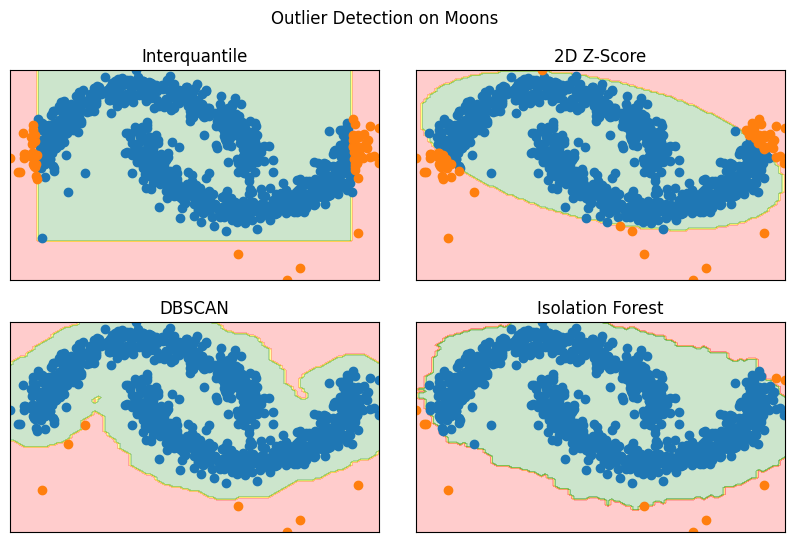

In [29]:
fig, axs = plt.subplots(2, 2, figsize = (10,6))
fig.subplots_adjust(wspace=0.1, hspace=0.2)
fig.suptitle("Outlier Detection on Moons")

# Interquantile 
interquantile_mapping= mapping["interquantile_outliers"].values.reshape(X1.shape)
axs[0,0].contourf(X1, X2, interquantile_mapping, alpha = 0.2, cmap = ListedColormap(('red', 'yellow','green')))

for c in df["interquantile_outliers"].unique():
    df_loc = df.loc[df["interquantile_outliers"] == c].copy()
    if c == -1: 
        axs[0,0].scatter(df_loc.feature_1, df_loc.feature_2, label = "Outlier")
    else: 
        axs[0,0].scatter(df_loc.feature_1, df_loc.feature_2, label = "Real Data")

axs[0,0].set_xticks([], [])
axs[0,0].set_yticks([], [])
axs[0,0].set_title("Interquantile")

# 2D Z Score 
z_score_mapping = mapping["z_score_2d_outliers"].values.reshape(X1.shape)
axs[0,1].contourf(X1, X2, z_score_mapping, alpha = 0.2, cmap = ListedColormap(('red', 'yellow','green')))

for c in df["z_score_2d_outliers"].unique():
    df_loc = df.loc[df["z_score_2d_outliers"] == c].copy()
    if c == -1: 
        axs[0,1].scatter(df_loc.feature_1, df_loc.feature_2, label = "Outlier")
    else: 
        axs[0,1].scatter(df_loc.feature_1, df_loc.feature_2, label = "Real Data")

axs[0,1].set_xticks([], [])
axs[0,1].set_yticks([], [])
axs[0,1].set_title("2D Z-Score")

# DBSCAN 
dbscan_mapping= mapping["dbscan_outliers"].values.reshape(X1.shape)
axs[1,0].contourf(X1, X2, dbscan_mapping, alpha = 0.2, cmap = ListedColormap(('red', 'yellow','green')))

for c in df["dbscan_outliers"].unique():
    df_loc = df.loc[df["dbscan_outliers"] == c].copy()
    if c == -1: 
        axs[1,0].scatter(df_loc.feature_1, df_loc.feature_2, label = "Outlier")
    else: 
        axs[1,0].scatter(df_loc.feature_1, df_loc.feature_2, label = "Real Data")

axs[1,0].set_xticks([], [])
axs[1,0].set_yticks([], [])
axs[1,0].set_title("DBSCAN")

# Isolation Forest 
iso_forest_mapping= mapping["iso_forest_outliers"].values.reshape(X1.shape)
axs[1,1].contourf(X1, X2, iso_forest_mapping, alpha = 0.2, cmap = ListedColormap(('red', 'yellow','green')))

for c in df["iso_forest_outliers"].unique():
    df_loc = df.loc[df["iso_forest_outliers"] == c].copy()
    if c == -1: 
        axs[1,1].scatter(df_loc.feature_1, df_loc.feature_2, label = "Outlier")
    else: 
        axs[1,1].scatter(df_loc.feature_1, df_loc.feature_2, label = "Real Data")

axs[1,1].set_xticks([], [])
axs[1,1].set_yticks([], [])
axs[1,1].set_title("Isolation Forest")

# Save and Show 
plt.savefig("img/outlier_detection.png", dpi = 300, bbox_inches='tight')
plt.show()